# UFC Fight Scoring - Regression - Data Preparation

## Import Libraries

In [1]:
from UFCStats.queries import DatabaseQuery

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

import warnings
warnings.filterwarnings('ignore')

## Run Queries

In [2]:
# Run queries to add db data to pandas dataframes
DQ = DatabaseQuery()

def query_to_df(query):
    df = pd.DataFrame(query.fetchall())
    df.columns = query.keys()
    return df

round_results_df = query_to_df(DQ.get_round_results())
fights_df = query_to_df(DQ.get_fights())
event_dates_df = query_to_df(DQ.get_event_dates())
round_scoring_df = query_to_df(DQ.get_round_scoring())

## Manipulate Data for Regression

In [3]:
# Create columns for judge score average and combined (judge + media) averages
fights_df['judge_fighter1_avg'] = fights_df[['judge1_fighter1','judge2_fighter1','judge3_fighter1']].mean(axis=1)
fights_df['judge_fighter2_avg'] = fights_df[['judge1_fighter2','judge2_fighter2','judge3_fighter2']].mean(axis=1)

fights_df['combined_fighter1_avg'] = fights_df.apply(lambda row: (row.media_fighter1 * row.media_count \
                                              + row.judge_fighter1_avg * 3) / (3 + row.media_count), axis=1)

fights_df['combined_fighter2_avg'] = fights_df.apply(lambda row: (row.media_fighter2 * row.media_count \
                                              + row.judge_fighter2_avg * 3) / (3 + row.media_count), axis=1)

In [4]:
# Add fight_id column and group table by fight_id and fighter_id
round_results_df['fight_id'] = round_results_df['rd_id'].str.split('-', 1, expand=True)[0]
round_results_df = round_results_df.drop(columns=['rd_id'])

round_results_df_grouped = round_results_df.groupby(['fight_id', 'fighter_id']).agg('sum').reset_index()

In [5]:
# Add aggregate columns for total significant strikes landed and taken
round_results_df_grouped['sig_strike_land'] = (round_results_df_grouped['sig_head_land'] + round_results_df_grouped['sig_body_land']
                                               + round_results_df_grouped['sig_leg_land'])
round_results_df_grouped['sig_strike_taken'] = (round_results_df_grouped['sig_head_taken'] + round_results_df_grouped['sig_body_taken']
                                                + round_results_df_grouped['sig_leg_taken'])

In [6]:
# Create disparity columns and drop all other stats columns
offensive_stats = ['kd',
                   'sig_head_land',
                   'sig_body_land',
                   'sig_leg_land',
                   'sig_dist_land',
                   'sig_clinch_land',
                   'sig_ground_land',
                   'sig_strike_land',
                   'total_strike_land',
                   'total_strike_att',
                   'takedown_land',
                   'takedown_att',
                   'sub_att',
                   'reversals',
                   'ctrl_time'
                  ]

defensive_stats = ['kd_taken',
                   'sig_head_taken',
                   'sig_body_taken',
                   'sig_leg_taken',
                   'sig_dist_taken',
                   'sig_clinch_taken',
                   'sig_ground_taken',
                   'sig_strike_taken',
                   'total_strike_taken',
                   'total_strike_seen',
                   'takedown_taken',
                   'takedown_seen',
                   'sub_seen',
                   'reversals_taken',
                   'ctrl_time_taken',
                  ]

keep_columns = ['fight_id',
                'fighter_id'
               ]

for o, d in zip(offensive_stats, defensive_stats):
    round_results_df_grouped[o + '_disparity'] = round_results_df_grouped[o] - round_results_df_grouped[d]
    keep_columns.append(o + '_disparity')

round_results_disparity = round_results_df_grouped[keep_columns]

In [7]:
# Create merging columns between round_results and fights to merge scoring data
fights_df['fight_id_fighter_1'] = fights_df['fight_id'] + '-' + fights_df['fighter_1_id']
fights_df['fight_id_fighter_2'] = fights_df['fight_id'] + '-' + fights_df['fighter_2_id']
round_results_disparity['fight_id_fighter'] = round_results_disparity['fight_id'] + '-' + round_results_disparity['fighter_id']

In [8]:
# Merge scoring and rds_sched columns from fights_df
fights_df_merge_cols_1 = ['fight_id_fighter_1',
                          'media_fighter1',
                          'judge_fighter1_avg',
                          'combined_fighter1_avg'
                         ]

fights_df_merge_cols_2 = ['fight_id_fighter_2',
                          'media_fighter2',
                          'judge_fighter2_avg',
                          'combined_fighter2_avg'
                         ]

round_results_merged = pd.merge(round_results_disparity, fights_df[['fight_id', 'rds_sched']],on='fight_id')

round_results_merged = pd.merge(round_results_merged, 
                                fights_df[fights_df_merge_cols_1],
                                how='left',
                                left_on='fight_id_fighter',
                                right_on='fight_id_fighter_1'
                               ).drop(columns='fight_id_fighter_1')

round_results_merged = pd.merge(round_results_merged, 
                                fights_df[fights_df_merge_cols_2],
                                how='left',
                                left_on='fight_id_fighter',
                                right_on='fight_id_fighter_2'
                               ).drop(columns='fight_id_fighter_2')

In [9]:
# Combine judge, media, and combined scoring columns and drop fighter1 and fighter2 columns and identifier columns
combined_columns = {'media_avg' : ['media_fighter1', 'media_fighter2'],
                    'judge_avg' : ['judge_fighter1_avg', 'judge_fighter2_avg'],
                    'combined_avg' : ['combined_fighter1_avg', 'combined_fighter2_avg']
                   }

round_results_merged = round_results_merged.set_index('fight_id_fighter')
drop_cols = ['fight_id', 'fighter_id']

for col in combined_columns:
    round_results_merged[col] = np.where(round_results_merged[combined_columns[col][0]].isnull(),
                                         round_results_merged[combined_columns[col][1]],
                                         round_results_merged[combined_columns[col][0]]
                                        )
    drop_cols.append(combined_columns[col][0])
    drop_cols.append(combined_columns[col][1])

round_results_merged = round_results_merged.drop(columns=drop_cols)

In [10]:
# Convert rds_sched to float and divide all remaining columns by rds_sched and drop rds_sched
round_results_merged['rds_sched'] = round_results_merged['rds_sched'].astype(float)
cols = round_results_merged.columns
round_results_merged[cols] = round_results_merged[cols].div(round_results_merged['rds_sched'], axis=0)
linear_reg_data = round_results_merged.drop(columns=['rds_sched'])

linear_reg_data.replace('', np.nan, inplace=True)
linear_reg_data.dropna(inplace=True)

In [11]:
linear_reg_data.head(10)

,kd_disparity,sig_head_land_disparity,sig_body_land_disparity,sig_leg_land_disparity,sig_dist_land_disparity,sig_clinch_land_disparity,sig_ground_land_disparity,sig_strike_land_disparity,total_strike_land_disparity,total_strike_att_disparity,takedown_land_disparity,takedown_att_disparity,sub_att_disparity,reversals_disparity,ctrl_time_disparity,media_avg,judge_avg,combined_avg
fight_id_fighter,,,,,,,,,,,,,,,,,,
0005e00b07cee542-578ef12674df1e6a,0.0,-8.600000,-8.800000,0.400000,-15.000000,0.600000,-2.600000,-17.000000,-19.000000,-26.400000,-1.000000,-2.800000,0.000000,0.000000,-62.600000,8.863636,8.933333,8.872000
0005e00b07cee542-634e2fb70bde3fd5,0.0,8.600000,8.800000,-0.400000,15.000000,-0.600000,2.600000,17.000000,19.000000,26.400000,1.000000,2.800000,0.000000,0.000000,62.600000,10.000000,10.000000,10.000000
003c84fc7c3fa028-49858bf46dabf6fb,0.0,1.666667,1.666667,9.333333,12.666667,-0.333333,0.333333,12.666667,12.333333,15.666667,0.000000,-0.666667,0.000000,0.000000,1.000000,10.000000,10.000000,10.000000
003c84fc7c3fa028-873626e5547b5235,0.0,-1.666667,-1.666667,-9.333333,-12.666667,0.333333,-0.333333,-12.666667,-12.333333,-15.666667,0.000000,0.666667,0.000000,0.000000,-1.000000,8.974359,9.000000,8.979167
0051d7fbb7893d27-282fa667ff9c51ed,0.0,1.000000,-1.333333,-1.666667,-2.333333,1.000000,-0.666667,-2.000000,-19.000000,-21.000000,-0.666667,-2.000000,0.333333,0.666667,-65.666667,9.666667,9.666667,9.666667
0051d7fbb7893d27-b6c4451cb13c9303,0.0,-1.000000,1.333333,1.666667,2.333333,-1.000000,0.666667,2.000000,19.000000,21.000000,0.666667,2.000000,-0.333333,-0.666667,65.666667,9.333333,9.333333,9.333333
00720c46f864fe03-3bad7ef643840f67,0.0,-1.000000,0.333333,-0.333333,-4.000000,3.000000,0.000000,-1.000000,4.000000,-1.333333,-1.333333,-1.000000,0.333333,0.000000,-131.333333,9.685185,9.444444,9.650794
00720c46f864fe03-bf43fed8f29e1671,0.0,1.000000,-0.333333,0.333333,4.000000,-3.000000,0.000000,1.000000,-4.000000,1.333333,1.333333,1.000000,-0.333333,0.000000,131.333333,9.333333,9.555556,9.365079
0072df705378477c-9b68bf67c5695185,0.0,-9.000000,-3.000000,1.333333,-5.666667,-1.666667,-3.333333,-10.666667,-22.666667,-25.333333,-1.000000,-2.000000,-0.333333,0.000000,-31.000000,9.222222,9.333333,9.277778


## Explore Collinearity

,kd_disparity,sig_head_land_disparity,sig_body_land_disparity,sig_leg_land_disparity,sig_dist_land_disparity,sig_clinch_land_disparity,sig_ground_land_disparity,sig_strike_land_disparity,total_strike_land_disparity,total_strike_att_disparity,takedown_land_disparity,takedown_att_disparity,sub_att_disparity,reversals_disparity,ctrl_time_disparity,rds_sched,media_avg,judge_avg,combined_avg
kd_disparity,1.000000,0.171835,0.080804,0.069829,0.137940,0.067077,0.154927,0.186659,0.131176,0.100211,-0.002121,-0.081527,-0.016642,0.000123,0.054112,NaN,0.226586,0.229917,0.228776
sig_head_land_disparity,0.171835,1.000000,0.222842,-0.031255,0.688558,0.362990,0.550074,0.843952,0.681116,0.621365,0.199188,-0.013241,0.027775,0.051209,0.279777,NaN,0.642215,0.650467,0.649391
sig_body_land_disparity,0.080804,0.222842,1.000000,0.180047,0.477165,0.477513,0.228071,0.582536,0.446973,0.415718,-0.001736,-0.101065,-0.003894,0.028831,0.049773,NaN,0.318543,0.330477,0.323736
sig_leg_land_disparity,0.069829,-0.031255,0.180047,1.000000,0.400329,0.194883,0.111057,0.396681,0.291459,0.247823,0.047063,0.050950,-0.029401,0.048715,0.104191,NaN,0.216224,0.220015,0.219560
sig_dist_land_disparity,0.137940,0.688558,0.477165,0.400329,1.000000,0.231772,0.101527,0.844054,0.535030,0.500105,-0.028333,-0.166355,0.004057,0.061862,-0.008695,NaN,0.487205,0.494653,0.493710
sig_clinch_land_disparity,0.067077,0.362990,0.477513,0.194883,0.231772,1.000000,0.154763,0.516992,0.429040,0.395148,0.039212,-0.056287,0.003489,0.031667,0.063563,NaN,0.312848,0.315666,0.315795
sig_ground_land_disparity,0.154927,0.550074,0.228071,0.111057,0.101527,0.154763,1.000000,0.546612,0.641676,0.553580,0.422814,0.259737,0.013446,0.030105,0.608814,NaN,0.562801,0.575956,0.569712
sig_strike_land_disparity,0.186659,0.843952,0.582536,0.396681,0.844054,0.516992,0.546612,1.000000,0.788778,0.715837,0.171349,-0.026827,0.009724,0.067281,0.272331,NaN,0.687262,0.699148,0.695835
total_strike_land_disparity,0.131176,0.681116,0.446973,0.291459,0.535030,0.429040,0.641676,0.788778,1.000000,0.884143,0.280514,0.103672,0.031406,0.024673,0.450574,NaN,0.662294,0.678008,0.670731
total_strike_att_disparity,0.100211,0.621365,0.415718,0.247823,0.500105,0.395148,0.553580,0.715837,0.884143,1.000000,0.200381,0.059051,0.007393,0.026822,0.374126,NaN,0.577010,0.587470,0.583916


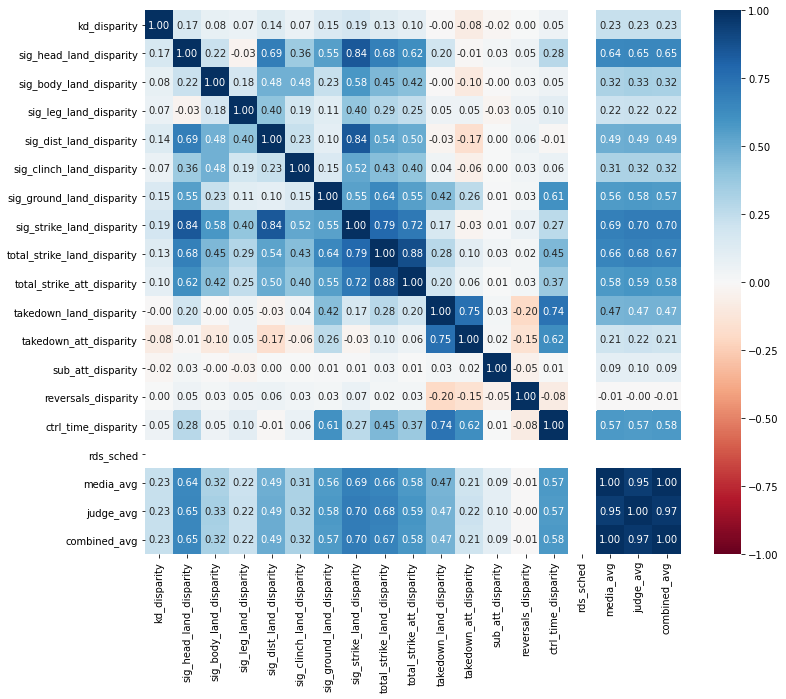

In [12]:
# Check for collinearity between variables
corr = round_results_merged.corr()

display(corr)
plt.figure(figsize=(12,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu', annot=True, fmt='.2f', vmin=-1.0);

#### Highly Correlated Variables

There are a number of variables that are very similar in nature that have high correlation.
- **sig_strike_land_disparity** - This variable correlates highly with sig_head_land_disparity and sig_distance_land_disparity. This signifies that, historically, stiking the head and striking at a distance are the more common methods of striking in our dataset.
- **takedown_land_disparity & takedown_att_disparity** - These variables have high correlation with a number of other variables. Attempting and landing takedowns correlates negatively with all striking variables. In particular, attempted takedowns correlates highly negatively with significant distance strikes landed. Landing takedowns also correlates negatively with reversals, which are generally performed by the fighter who was taken down. Takedowns landed do have a strong positive correlation with control time (ctrl_time_disparity).
- **total_strike_land_disparity** - This variable  correlates highly with total_strike_att_disparity and sig_strike_land_disparity.


#### Variance Inflation Factor
Before dropping variables, I'll run a variance inflation factor test for multicollinearity.

In [13]:
# Drop output variables to perform for VIF calculation
output_var = ['media_avg', 'judge_avg', 'combined_avg']
linear_reg_vif = linear_reg_data.drop(columns=output_var)

# Create constant and run vif calculation
X = sm.tools.add_constant(linear_reg_vif)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
display(vif)

const                          1.000000
kd_disparity                   1.061270
sig_head_land_disparity             inf
sig_body_land_disparity             inf
sig_leg_land_disparity              inf
sig_dist_land_disparity             inf
sig_clinch_land_disparity           inf
sig_ground_land_disparity           inf
sig_strike_land_disparity           inf
total_strike_land_disparity    6.901894
total_strike_att_disparity     4.691639
takedown_land_disparity        3.409027
takedown_att_disparity         2.659144
sub_att_disparity              1.008777
reversals_disparity            1.069560
ctrl_time_disparity            3.179627
dtype: float64

As seen above, the striking variables correlate too closely, particularly because I've included significant strike breakdowns as well as total significant strikes and total strikes (attempted and landed). I will remove the following variables. The resulting VIF output printed below is more reasonable.
- **sig_body_land_disparity** - This has a negative correlation with output variables, but it's because landing to the body means less head damage. A positive disparity here should theoretically have a positive correlation to judges' scoring.
- **sig_leg_land_disparity** - This behaves the same as sig_body_land_disparity. A positive disparity correlates negatively with scoring.
- **sig_dist_land_disparity** - I want to keep sig_strike_land_disparity, as significant strikes are a key component of the scoring rubric for judges. Distance striking correlates highly with total significant strikes landed, so this variable will be removed.
- **sig_clinch_land_disparity** - This behaves the same as sig_body_land_disparity. A positive disparity correlates negatively with scoring.
- **total_strike_land_disparity** - This correlates very strongly with sig_strike_land_disparity, which is a more important variable.
- **reversals_disparity** - This has a high negative correlation with takedown_land_disparity. The fighter who is taken down is the fighter with opportunities for reversals. THis is redundant.

NOTE:  I am also dropping sig_ground_land_disparity. In model evaluation, this feature had a nonsensical negative coefficient. Removing the feature had minimal impact on model performance.

In [14]:
# Drop variables for VIF calculation.
drop_vars = ['sig_body_land_disparity', 'sig_leg_land_disparity', 'sig_dist_land_disparity', 
             'sig_clinch_land_disparity', 'total_strike_land_disparity','reversals_disparity', 
             'sig_ground_land_disparity'
            ]
linear_reg_vif = linear_reg_vif.drop(columns=drop_vars)

# Create constant and run vif calculation
X = sm.tools.add_constant(linear_reg_vif)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
display(vif)

const                         1.000000
kd_disparity                  1.052729
sig_head_land_disparity       3.565514
sig_strike_land_disparity     4.453875
total_strike_att_disparity    2.253429
takedown_land_disparity       3.295366
takedown_att_disparity        2.633703
sub_att_disparity             1.003153
ctrl_time_disparity           2.602345
dtype: float64

#### Pairwise Plot
To further examine correlations between variables, I've created a pairwise plot below. There are certainly some clear correlations between some of the remaining variables. Notably, and as expected based on the correlation heatmap, **sig_head_land_disparity** correlates strongly with **sig_strike_land_disparity**. There is also high correlation between **takedown_land_disparity** and both **takedown_att_disparity** and **ctrl_time_disparity**. It's also notable that **ctrl_time disparity** has a semi-strong correlation with more or less all other variables. This is because the fighter in control is typically the fighter landing more offense. I will keep these correlations in mind as I run the regression models and make adjustments as needed.

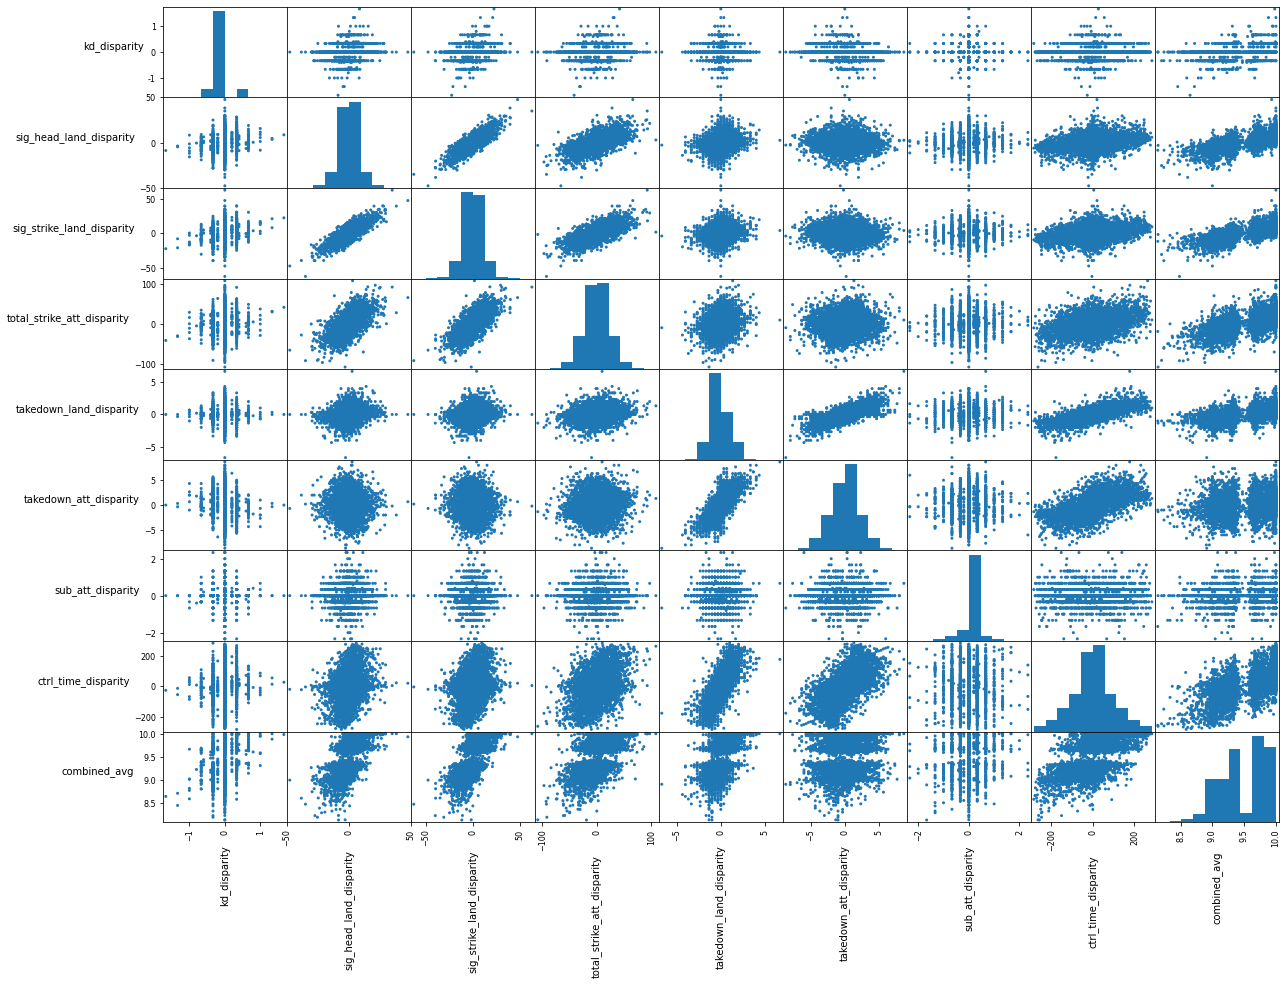

In [15]:
drop_vars = ['sig_body_land_disparity', 'sig_leg_land_disparity', 'sig_dist_land_disparity', 
             'sig_clinch_land_disparity', 'total_strike_land_disparity','reversals_disparity', 
             'sig_ground_land_disparity', 'media_avg', 'judge_avg'
            ]

axes = pd.plotting.scatter_matrix(linear_reg_data.drop(columns=drop_vars), alpha=1, figsize=(20,15))
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.show()

## Describing the Dataset

- The first thing to notice below is that the mean of all input variables is 0. This is because each input variable represents the disparity between the fighters in a fight for a given metric, and I am including a record for both the winning and the losing fighter of each fight in the dataset. For example, if fighter_1 landed 50 more significant strikes than fighter_2 in a given fight, there would be one record showing a +50 disparity for fighter_1 and a second record showing a -50 disparity for fighter_2. As such, these metrics should all have a zero mean.
- You'll also notice that the first and third quartiles are equal for all input variables. Min and max are also equal. Because we add opposing records for each fighter in a fight, the independent variables each have a normal distribution.
- One last observation is that kd_disparity and sub_attempt_disparity have first and third quartiles equal to the mean at zero. This means that, in many fights, knockdowns and submission attempts are equal between the fighters. This is probably because each fighter had zero knockdowns or zero submission attempts. Instances of knockdowns and submission attempts, while not entirely rare, are significantly less common than the other variables in our dataset.

All of this information looks reasonable. No additional data cleaning should be required.

In [16]:
# Filter data for relevant columns and a single output variable (combined_avg)
linear_reg_data_filtered = linear_reg_data.drop(columns=drop_vars)

In [17]:
linear_reg_data_filtered.describe()

,kd_disparity,sig_head_land_disparity,sig_strike_land_disparity,total_strike_att_disparity,takedown_land_disparity,takedown_att_disparity,sub_att_disparity,ctrl_time_disparity,combined_avg
count,4516.000000,4516.000000,4516.00000,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000
mean,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,9.480189
std,0.175165,7.740570,9.94359,23.866425,1.003535,2.246023,0.354823,99.060779,0.365100
min,-1.666667,-47.666667,-62.40000,-108.333333,-6.666667,-8.666667,-2.333333,-284.000000,8.140351
25%,0.000000,-4.333333,-6.00000,-14.616667,-0.666667,-1.333333,0.000000,-53.700000,9.214286
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,9.421053
75%,0.000000,4.333333,6.00000,14.616667,0.666667,1.333333,0.000000,53.700000,9.777778
max,1.666667,47.666667,62.40000,108.333333,6.666667,8.666667,2.333333,284.000000,10.000000


## Save Clean Data

In [18]:
# Pickle the final data
with open('pickle_linear_reg_data.pickle', 'wb') as to_write:
    pickle.dump(linear_reg_data_filtered, to_write)